In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter

import cv2
from tqdm import tqdm
import pickle

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
X = []
Y = []
x_train = []
x_test = []
y_train = []
seed = 37

In [3]:
df_train = pd.read_csv('train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
labels_list = df_train.tags.str.split().tolist()

counter = Counter()
for item in labels_list:
    counter.update(item)

label_counts = dict(counter)
print label_counts

{'cultivation': 4547, 'primary': 37513, 'water': 7411, 'artisinal_mine': 339, 'habitation': 3660, 'bare_ground': 862, 'blow_down': 101, 'agriculture': 12315, 'selective_logging': 340, 'clear': 28431, 'conventional_mine': 100, 'cloudy': 2089, 'haze': 2697, 'slash_burn': 209, 'partly_cloudy': 7261, 'blooming': 332, 'road': 8071}


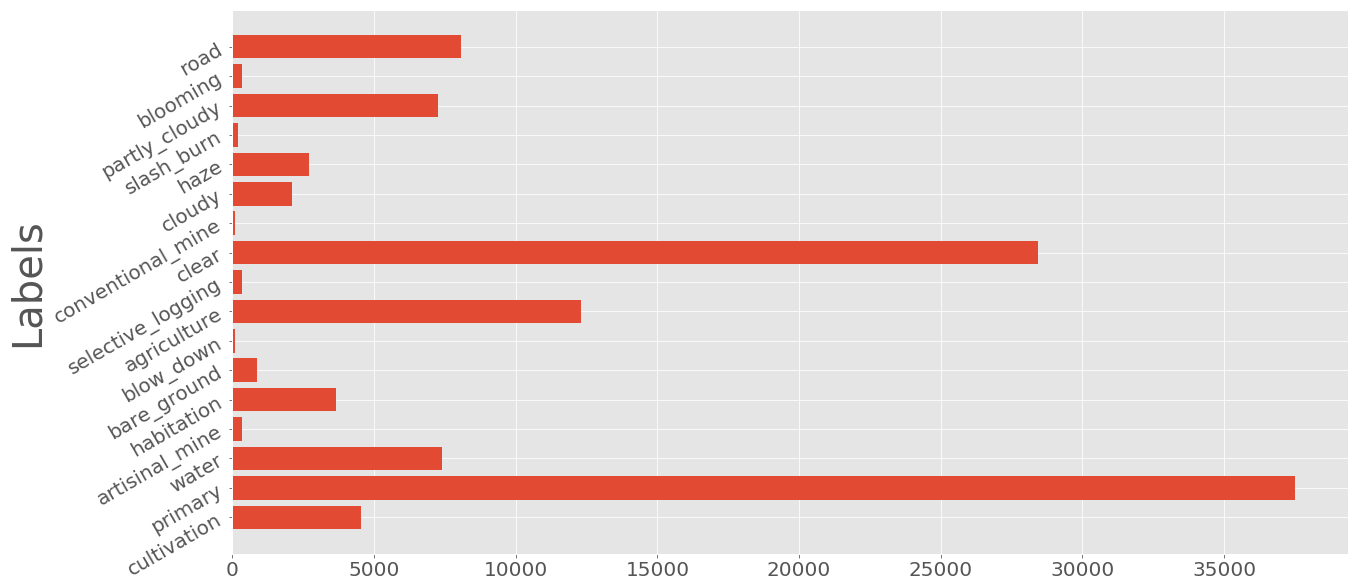

In [5]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.barh(range(len(label_counts)), label_counts.values(), align='center')
plt.yticks(range(len(label_counts)), label_counts.keys(), rotation=30 )
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.ylabel('Labels', fontsize=40)
plt.show()

In [6]:
label_map = {}
i = 0
for key,value in label_counts.iteritems():
    label_map[key] = i
    i +=1

inv_label_map = {i: l for l, i in label_map.items()}
    
print label_map  
print inv_label_map

{'slash_burn': 13, 'selective_logging': 8, 'clear': 9, 'blooming': 15, 'primary': 1, 'cloudy': 11, 'conventional_mine': 10, 'water': 2, 'haze': 12, 'cultivation': 0, 'partly_cloudy': 14, 'artisinal_mine': 3, 'habitation': 4, 'bare_ground': 5, 'blow_down': 6, 'agriculture': 7, 'road': 16}
{0: 'cultivation', 1: 'primary', 2: 'water', 3: 'artisinal_mine', 4: 'habitation', 5: 'bare_ground', 6: 'blow_down', 7: 'agriculture', 8: 'selective_logging', 9: 'clear', 10: 'conventional_mine', 11: 'cloudy', 12: 'haze', 13: 'slash_burn', 14: 'partly_cloudy', 15: 'blooming', 16: 'road'}


In [7]:
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor


def get_training_test_data(df):
    for fname, tags in tqdm(df.values):
        img_name = ("train-jpg/%s.jpg")% (fname)
        img = cv2.imread(img_name)
        labels = np.zeros(17)
        for tag in tags.split(' '):
            labels[label_map[tag]] = 1
        X.append(cv2.resize(img, (32,32),interpolation = cv2.INTER_LINEAR))
        Y.append(labels)            

with ThreadPoolExecutor(64) as pool:
    pool.map(get_training_test_data(df_train))

100%|██████████| 40479/40479 [02:47<00:00, 241.66it/s]


' \n    for fname, tags in tqdm(df_train.values):\n        img_name = ("train-jpg/%s.jpg")% (fname)\n        img = cv2.imread(img_name)\n        labels = np.zeros(17)\n        for tag in tags.split(\' \'):\n            labels[label_map[tag]] = 1\n        X.append(cv2.resize(img, (64,64),interpolation = cv2.INTER_LINEAR))\n        Y.append(labels)\n'

In [8]:
def normalize(x):
    X = np.asarray(x,dtype=np.float64)
    X_min = np.min(X)
    X_max = np.max(X)
    X -= X_min
    X /= (X_max-X_min)
    
    return X

map(normalize, X)

X = np.array(X, np.float16)
Y = np.array(Y, np.float16)

print X.shape
print Y.shape

(40479, 32, 32, 3)
(40479, 17)


In [9]:
with open("tmp.pickle", "wb") as f:
    pickle.dump((X,Y), f)
print 'Pickle saved'

Pickle saved


In [10]:
with open("tmp.pickle", "rb") as f:
    X,Y = pickle.load(f)
print 'Pickle loaded'

Pickle loaded


In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [22]:
x_train, x_valid, y_train, y_valid =  train_test_split(X, Y, test_size=0.2, random_state=seed)

In [23]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_valid, y_valid))

Train on 32383 samples, validate on 8096 samples
Epoch 1/10
32383/32383 [==============================] - 270s - loss: 0.2847 - acc: 0.9048 - val_loss: 0.2031 - val_acc: 0.9244
Epoch 2/10
32383/32383 [==============================] - 268s - loss: 0.2022 - acc: 0.9207 - val_loss: 0.1855 - val_acc: 0.9304
Epoch 3/10
32383/32383 [==============================] - 252s - loss: 0.1861 - acc: 0.9272 - val_loss: 0.1864 - val_acc: 0.9255
Epoch 4/10
32383/32383 [==============================] - 260s - loss: 0.1805 - acc: 0.9291 - val_loss: 0.1740 - val_acc: 0.9321
Epoch 5/10
32383/32383 [==============================] - 255s - loss: 0.1752 - acc: 0.9307 - val_loss: 0.1706 - val_acc: 0.9307
Epoch 6/10
32383/32383 [==============================] - 254s - loss: 0.1732 - acc: 0.9312 - val_loss: 0.1642 - val_acc: 0.9352
Epoch 7/10
32383/32383 [==============================] - 267s - loss: 0.1683 - acc: 0.9333 - val_loss: 0.1577 - val_acc: 0.9373
Epoch 8/10
32383/32383 [========================

In [25]:
model.save('benchmark_model.h5')
print 'Model saved'

Model saved


In [26]:
model = load_model("benchmark_model.h5")
print 'Model loaded'

Model loaded


In [46]:
pred_valid = model.predict(x_valid, batch_size=128)

for i in range(10):
    print 'True labels:', y_valid[i].astype(int)
    print 'Pred labels:', np.array(pred_valid[i]>0.2).astype(int)

print 'F score: ', (fbeta_score(y_valid, np.array(pred_valid) > 0.2, beta=2, average='samples'))

True labels: [0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
Pred labels: [0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
True labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Pred labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
True labels: [1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
Pred labels: [0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
True labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Pred labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
True labels: [0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
Pred labels: [0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1]
True labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Pred labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
True labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Pred labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
True labels: [0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1]
Pred labels: [1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1]
True labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Pred labels: [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
True labels: [0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1]
Pred labels: [0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1]
F score:  0.85266828